# Imports

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from structs.utils import fc1_config, encoder_config, decoder_config
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from structs.models import ColoredMNISTModel
from structs.models import EnhancedSAE, SimpleSAE

torch.manual_seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

In [15]:
import os 
path = '/Volumes/Ayush_Drive/mnist'

if os.path.exists(path):
    prefix = path
else:
    prefix = ''

# Activation Generation

## Structure 
- activations : dict [depth, activations]
- labels : [labels] for the activations 
- All activations to start with?

### Load in the sae-models and the mnist models and pass the value in? 


In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms


class ToRGB:
    def __call__(self, img):
        return img.repeat(3, 1, 1)  # Repeat the grayscale channel 3 times

# Updated transforms for colored MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    ToRGB(),  # Convert to RGB
    transforms.Normalize(mean=[0.1307, 0.1307, 0.1307],  # Same normalization for each channel
                       std=[0.3081, 0.3081, 0.3081])
])

# Load datasets
train_dataset = datasets.MNIST(root=f'{prefix}/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=f'{prefix}/data', train=False, download=True, transform=transform)
dataset = ConcatDataset([train_dataset, test_dataset])

# Create data loaders
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from structs.models import ColoredMNISTModel

mnist_model = ColoredMNISTModel()
mnist_model.load_state_dict(torch.load(os.path.join(path, 'models', 'mnist_colored.pth'))) #load in the mnist model 

In [ ]:
from structs.models import EnhancedSAE, SimpleSAE

saes = {}

#first one is special 
sae_model = SimpleSAE(input_dim=fc1_config.input_dim, hidden_dim=encoder_config.input_dim)
model_path = os.path.join(path, 'models', 'mnist-colored_sae_MNIST_depth_1.pth')
sae_model.load_state_dict(torch.load(model_path))

saes[1] = sae_model

for i in tqdm(range(2, 10), desc="Loading SAE models"):
    sae_model = SimpleSAE(input_dim=encoder_config.input_dim, hidden_dim=encoder_config.input_dim)
    model_path = os.path.join(path, 'models', f'mnist-colored_sae_MNIST_depth_{i}.pth')
    sae_model.load_state_dict(torch.load(model_path))
    saes[i] = sae_model

In [ ]:
labels = train_dataset.targets.tolist() + test_dataset.targets.tolist()

# Get Cached Activations

In [ ]:
# given a model and a dataset run it and save the activations as well as returning them. 
def get_activations(model, dataset, layer_name):
    model.clear_cache()
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataset):
            model(images)
    
    return model.get_cached_activations(layer_name)

# get the activations for the encoder layer
def get_sae_activations(sae, dataset, layer_name):
    sae.clear_cache()
    sae.eval()
    activations = []
    with torch.no_grad():
        for images in tqdm(dataset):
            encoded, _ = sae(images)
            activations.append(encoded)

    return torch.stack(activations, dim=0)

## Get MNIST Activations

In [ ]:
mnist_activations = get_activations(mnist_model, dataset, 'fc1')
torch.save(mnist_activations, os.path.join(path, 'embeddings', 'mnist_fc1_activations.pth'))

## Get SAE Activations

In [ ]:
activation_dict = {}

In [34]:
mnist_activations = torch.load(os.path.join(path, 'embeddings', 'mnist_fc1_activations.pth'))

/var/folders/24/njx_3v7n0nj9kkzrv028sllm0000gn/T/ipykernel_32864/516488893.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mnist_activations = torch.load(os.path.join(pa

In [ ]:
prev_activations = torch.load(os.path.join(path, 'embeddings', f'mnist_encoder_fc1_depth_7.pth'))

for i in range(8, 10):
    activations = get_sae_activations(saes[i], prev_activations ,encoder_config.name)
    print(activations.shape)
    activation_dict[i] = activations 
    torch.save(activations, os.path.join(path, 'embeddings', f'mnist_encoder_fc1_depth_{i}.pth'))
    print(f'saved at depth {i}')
    prev_activations = activations

# Analysis

## Inputs
- Activation_dict
- Loaded Models 

### Load Activations and Models

In [16]:
from structs.models import EnhancedSAE, SimpleSAE

saes = {}

#first one is special 
sae_model = SimpleSAE(input_dim=fc1_config.input_dim, hidden_dim=encoder_config.input_dim)
model_path = os.path.join(path, 'models', 'mnist-colored_sae_MNIST_depth_1.pth')
sae_model.load_state_dict(torch.load(model_path))

saes[1] = sae_model

for i in tqdm(range(2, 10), desc="Loading SAE models"):
    sae_model = SimpleSAE(input_dim=encoder_config.input_dim, hidden_dim=encoder_config.input_dim)
    model_path = os.path.join(path, 'models', f'mnist-colored_sae_MNIST_depth_{i}.pth')
    sae_model.load_state_dict(torch.load(model_path))
    saes[i] = sae_model

/var/folders/24/njx_3v7n0nj9kkzrv028sllm0000gn/T/ipykernel_88972/4075164912.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_model.load_state_dict(torch.load(model_pa

In [17]:
activation_dict = {}

for i in tqdm(range(1, 10), desc="loading activations"):
    activation_dict[i] = torch.load(os.path.join(path, 'embeddings', f'mnist_encoder_fc1_depth_{i}.pth'))

loading activations:   0%|          | 0/9 [00:00<?, ?it/s]/var/folders/24/njx_3v7n0nj9kkzrv028sllm0000gn/T/ipykernel_88972/3769050316.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

In [25]:
labels = train_dataset.targets.tolist() + test_dataset.targets.tolist()

### CSP

In [57]:
def compute_csp(activations_by_depth, labels, depth):
    """Compute Concept Selectivity Progression score at a specific depth."""
    # Get activations for this depth

    activations = activations_by_depth[depth]
    labels_tensor = torch.tensor(labels)

    # Compute class-conditional activation distributions
    num_classes = 10  # For MNIST
    class_activations = [activations[labels_tensor == c] for c in range(num_classes)]
    
    # Compute selectivity for each feature
    num_features = activations.shape[1]
    feature_selectivity = torch.zeros(num_features)
    
    for feature_idx in range(num_features):
        # Get mean activation per class for this feature
        class_means = torch.tensor([
            class_act[:, feature_idx].mean() if len(class_act) > 0 else 0.0
            for class_act in class_activations
        ])
        
        # Compute selectivity as (max_class_mean - second_max_class_mean) / max_class_mean
        sorted_means, _ = torch.sort(class_means, descending=True)
        if sorted_means[0] > 0:
            feature_selectivity[feature_idx] = (sorted_means[0] - sorted_means[1]) / sorted_means[0]
        else:
            feature_selectivity[feature_idx] = 0
    
    # Average selectivity across all features
    csp_score = feature_selectivity.mean().item()
    
    return csp_score

In [59]:
concept_scores = []
for i in range(1, 10):
    csp = compute_csp(activations_by_depth=activation_dict, labels=labels, depth=i)
    concept_scores.append(csp)

In [60]:
concept_scores

[0.38325271010398865,
 0.2948255240917206,
 0.2948392629623413,
 0.28127816319465637,
 0.34276822209358215,
 0.49925675988197327,
 0.33006981015205383,
 0.03071661852300167,
 0.0008410031441599131]

### Progressive Disentanglement Scores

In [64]:
def compute_pds(activations_by_depth, depth):
    """Compute Progressive Disentanglement Score between depth-1 and depth."""
    if depth <= 1:
        return 0.0  # No previous depth to compare with
    
    # Get activations for current and previous depth
    act_current = activations_by_depth[depth]
    act_prev = activations_by_depth[depth-1]
    
    # Compute normalized covariance matrices
    def compute_normalized_covariance(activations):
        # Center the activations
        centered = activations - activations.mean(dim=0, keepdim=True)
        
        # Compute covariance matrix
        n_samples = activations.shape[0]
        cov = (centered.T @ centered) / (n_samples - 1)
        
        # Normalize by diagonal elements
        diag = torch.diag(cov)
        outer_sqrt_diag = torch.sqrt(diag).unsqueeze(1) @ torch.sqrt(diag).unsqueeze(0)
        norm_cov = cov / (outer_sqrt_diag + 1e-8)
        
        return norm_cov
    
    norm_cov_current = compute_normalized_covariance(act_current)
    norm_cov_prev = compute_normalized_covariance(act_prev)
    
    # Compute off-diagonal mass
    def compute_off_diagonal_mass(norm_cov):
        n = norm_cov.shape[0]
        mask = torch.ones(n, n) - torch.eye(n)
        return (torch.abs(norm_cov) * mask).sum() / (n * (n-1))
    
    odm_current = compute_off_diagonal_mass(norm_cov_current)
    odm_prev = compute_off_diagonal_mass(norm_cov_prev)
    
    # Progressive disentanglement score (positive means improvement)
    pds_score = odm_prev.item() - odm_current.item()
    
    return pds_score


In [65]:
pds_scores = []
for i in range(1, 10):
    pds = compute_pds(activations_by_depth=activation_dict, depth=i)
    pds_scores.append(pds)

In [66]:
pds_scores

[0.0,
 0.015452370047569275,
 0.005533084273338318,
 0.0007009357213973999,
 -0.0019735395908355713,
 0.011358387768268585,
 0.06025970773771405,
 0.004915809749945765,
 4.895937147648586e-06]

In [13]:
def compute_fasp(activations_by_depth, depth, percentile_threshold=95):
    """
    Compute Feature Activation Sparsity Progression at a specific depth.
    Measures how concentrated each feature's activations become across samples.
    
    Args:
        activations_by_depth: Dictionary mapping depth to activation tensors
        depth: The depth to compute the score for
        percentile_threshold: Percentile threshold to determine significant activations
    
    Returns:
        FASP score and percentage of samples that significantly activate each feature
    """
    activations = activations_by_depth[depth]
    num_samples, num_features = activations.shape
    
    # For each feature, calculate what percentage of samples significantly activate it
    feature_sparsity = torch.zeros(num_features)
    
    for feature_idx in range(num_features):
        feature_acts = activations[:, feature_idx]
        
        # Define significant activation threshold as percentile of non-zero values
        non_zero_acts = feature_acts[feature_acts > 0]
        if len(non_zero_acts) > 0:
            threshold = torch.quantile(non_zero_acts, percentile_threshold/100)
            # Calculate percentage of samples that significantly activate this feature
            significant_activations = (feature_acts > threshold).sum().float() / num_samples
            feature_sparsity[feature_idx] = 1.0 - significant_activations  # Higher is more sparse
        else:
            feature_sparsity[feature_idx] = 1.0  # Feature never activates (maximally sparse)
    
    # Average sparsity across all features
    fasp_score = feature_sparsity.mean().item()
    
    # Calculate percentage of samples that significantly activate each feature (for analysis)
    activation_percentages = 100 * (1.0 - feature_sparsity)
    
    return fasp_score, activation_percentages

In [ ]:
fasp_scores = []
for i in tqdm(range(1, 10)):
    fasp = compute_fasp(activations_by_depth=activation_dict, depth=i)
    fasp_scores.append(fasp)
fasp_scores

100%|██████████| 9/9 [01:16<00:00,  8.55s/it]


[(0.9870518445968628,
  tensor([1.0314, 0.5843, 1.5400,  ..., 0.9843, 1.2914, 0.8057])),
 (0.9807422161102295,
  tensor([1.7900, 1.4114, 3.0629,  ..., 0.5100, 2.0929, 3.8600])),
 (0.9800059199333191,
  tensor([0.0543, 2.4229, 3.0029,  ..., 0.1329, 1.2057, 2.8814])),
 (0.9789162874221802,
  tensor([0.0586, 3.7014, 2.1529,  ..., 0.7871, 1.6229, 4.4243])),
 (0.9847898483276367,
  tensor([2.8551e-03, 1.3900e+00, 6.9714e-01,  ..., 3.9000e-01, 3.4000e-01,
          4.7043e+00])),
 (0.9953942894935608,
  tensor([0.0000, 0.5143, 0.0343,  ..., 0.0457, 0.1600, 3.5643])),
 (0.9995087385177612,
  tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2914])),
 (0.999974250793457, tensor([0., 0., 0.,  ..., 0., 0., 0.])),
 (0.999998927116394, tensor([0., 0., 0.,  ..., 0., 0., 0.]))]

In [22]:
for f, p in fasp_scores:
    print('fasp', f)
    print('percentages', p)
    print('-'*10)

fasp 0.9870518445968628
percentages tensor([1.0314, 0.5843, 1.5400,  ..., 0.9843, 1.2914, 0.8057])
----------
fasp 0.9807422161102295
percentages tensor([1.7900, 1.4114, 3.0629,  ..., 0.5100, 2.0929, 3.8600])
----------
fasp 0.9800059199333191
percentages tensor([0.0543, 2.4229, 3.0029,  ..., 0.1329, 1.2057, 2.8814])
----------
fasp 0.9789162874221802
percentages tensor([0.0586, 3.7014, 2.1529,  ..., 0.7871, 1.6229, 4.4243])
----------
fasp 0.9847898483276367
percentages tensor([2.8551e-03, 1.3900e+00, 6.9714e-01,  ..., 3.9000e-01, 3.4000e-01,
        4.7043e+00])
----------
fasp 0.9953942894935608
percentages tensor([0.0000, 0.5143, 0.0343,  ..., 0.0457, 0.1600, 3.5643])
----------
fasp 0.9995087385177612
percentages tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2914])
----------
fasp 0.999974250793457
percentages tensor([0., 0., 0.,  ..., 0., 0., 0.])
----------
fasp 0.999998927116394
percentages tensor([0., 0., 0.,  ..., 0., 0., 0.])
----------


### Measure Weight Vector Changes

In [6]:
import math 

def compute_pairwise_cosine_similarities(weight_matrix):
    """
    Compute pairwise cosine similarities between weight vectors
    
    Args:
        weight_matrix: Tensor of shape [num_neurons, feature_dim]
        
    Returns:
        Tensor of shape [num_neurons, num_neurons] with cosine similarities
    """
    # Normalize the weight vectors
    weight_norms = torch.norm(weight_matrix, dim=1, keepdim=True)
    normalized_weights = weight_matrix / (weight_norms + 1e-8)  # Avoid division by zero
    
    # Compute cosine similarities (dot product of normalized vectors)
    cosine_similarities = torch.mm(normalized_weights, normalized_weights.t())
    
    return cosine_similarities

def compute_pairwise_angles(cosine_similarities):
    """Convert cosine similarities to angles in degrees"""
    # Clip to avoid numerical issues
    cosine_similarities_clipped = torch.clamp(cosine_similarities, -1.0, 1.0)
    angles = torch.acos(cosine_similarities_clipped) * (180.0 / math.pi)
    return angles

def analyze_weight_angles(max_depth=9):
    """Analyze the distribution of angles between weight vectors across depths"""
    # Store results
    angle_stats = []
    similarity_distributions = []
    
    # Loop through each depth
    for depth in range(1, max_depth + 1):

        print(f"Analyzing depth {depth}...")
        model = saes[depth]
        
        # Get the encoder weights (shape: [hidden_dim, input_dim])
        encoder_weights = model.encoder.weight.data
        
        # Compute pairwise cosine similarities
        cosine_similarities = compute_pairwise_cosine_similarities(encoder_weights)
        
        # Convert to angles
        angles = compute_pairwise_angles(cosine_similarities)
        
        # Remove self-similarities (diagonal)
        mask = ~torch.eye(angles.shape[0], dtype=torch.bool)
        angles_no_diag = angles[mask]
        
        # Calculate statistics
        angle_mean = angles_no_diag.mean().item()
        angle_median = angles_no_diag.median().item()
        angle_std = angles_no_diag.std().item()
        angle_min = angles_no_diag.min().item()
        angle_max = angles_no_diag.max().item()
        
        # Calculate percentiles
        percentiles = [10, 25, 50, 75, 90]
        angle_percentiles = torch.tensor([torch.quantile(angles_no_diag, q/100) for q in percentiles])
        
        # Store the stats
        angle_stats.append({
            'depth': depth,
            'mean': angle_mean,
            'median': angle_median,
            'std': angle_std,
            'min': angle_min,
            'max': angle_max,
            'percentiles': {p: v.item() for p, v in zip(percentiles, angle_percentiles)}
        })
        
        # Store the distribution for later plotting
        similarity_distributions.append(angles_no_diag.cpu().numpy())
        
        print(f"Depth {depth}: Mean angle = {angle_mean:.2f}°, Median = {angle_median:.2f}°")

    return angle_stats, similarity_distributions


In [7]:
angle_stats, similarity_distributions = analyze_weight_angles()


Analyzing depth 1...
Depth 1: Mean angle = 87.07°, Median = 87.07°
Analyzing depth 2...
Depth 2: Mean angle = 89.85°, Median = 89.85°
Analyzing depth 3...
Depth 3: Mean angle = 89.90°, Median = 89.90°
Analyzing depth 4...
Depth 4: Mean angle = 90.00°, Median = 90.00°
Analyzing depth 5...
Depth 5: Mean angle = 90.00°, Median = 90.00°
Analyzing depth 6...
Depth 6: Mean angle = 90.00°, Median = 90.00°
Analyzing depth 7...
Depth 7: Mean angle = 90.00°, Median = 90.00°
Analyzing depth 8...
Depth 8: Mean angle = 90.00°, Median = 90.00°
Analyzing depth 9...
Depth 9: Mean angle = 90.00°, Median = 90.00°


In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 

def plot_angle_stats(angle_stats):
    """Plot statistics about angles across depths"""
    depths = [stat['depth'] for stat in angle_stats]
    means = [stat['mean'] for stat in angle_stats]
    medians = [stat['median'] for stat in angle_stats]
    stds = [stat['std'] for stat in angle_stats]
    
    # Plot means and medians
    plt.figure(figsize=(10, 6))
    plt.plot(depths, means, 'o-', label='Mean Angle')
    plt.plot(depths, medians, 's-', label='Median Angle')
    plt.fill_between(depths, 
                    [mean - std for mean, std in zip(means, stds)],
                    [mean + std for mean, std in zip(means, stds)],
                    alpha=0.2)
    
    plt.xlabel('SAE Depth')
    plt.ylabel('Angle (degrees)')
    plt.title('Mean and Median Angles Between Weight Vectors Across SAE Depths')
    plt.xticks(depths)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # plt.savefig('angle_stats_across_depths.png', dpi=300, bbox_inches='tight')
    
    # Plot percentiles
    plt.figure(figsize=(10, 6))
    for p in [10, 25, 50, 75, 90]:
        percentiles = [stat['percentiles'][p] for stat in angle_stats]
        plt.plot(depths, percentiles, '.-', label=f'{p}th Percentile')
    
    plt.xlabel('SAE Depth')
    plt.ylabel('Angle (degrees)')
    plt.title('Angle Percentiles Between Weight Vectors Across SAE Depths')
    plt.xticks(depths)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # plt.savefig('angle_percentiles_across_depths.png', dpi=300, bbox_inches='tight')

def plot_angle_distributions(similarity_distributions, angle_stats):
    """Plot distributions of angles across depths"""
    depths = [stat['depth'] for stat in angle_stats]
    
    # Violin plot
    plt.figure(figsize=(12, 8))
    violin_data = [dist for dist in similarity_distributions]
    
    sns.violinplot(data=violin_data, palette="Set3")
    plt.xlabel('SAE Depth')
    plt.ylabel('Angle (degrees)')
    plt.title('Distribution of Angles Between Weight Vectors Across SAE Depths')
    plt.xticks(range(len(depths)), depths)
    plt.grid(True, alpha=0.3)
    # plt.savefig('angle_distributions_violin.png', dpi=300, bbox_inches='tight')
    
    # Histogram evolution
    plt.figure(figsize=(12, 8))
    for i, (dist, depth) in enumerate(zip(similarity_distributions, depths)):
        sns.kdeplot(dist, label=f'Depth {depth}', alpha=0.7)
    
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Distribution of Angles Between Weight Vectors Across SAE Depths')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # plt.savefig('angle_distributions_kde.png', dpi=300, bbox_inches='tight')

def calculate_orthogonality_metrics(angle_stats, similarity_distributions):
    """Calculate metrics related to orthogonality of the weight vectors"""
    depths = [stat['depth'] for stat in angle_stats]
    
    # Percentage of angles close to 90 degrees (orthogonal)
    ortho_threshold = 10  # within 10 degrees of orthogonal
    near_ortho_percentages = []
    
    for dist in similarity_distributions:
        # Count angles between 80-100 degrees
        near_ortho = np.sum((dist >= 90-ortho_threshold) & (dist <= 90+ortho_threshold))
        percentage = 100 * near_ortho / len(dist)
        near_ortho_percentages.append(percentage)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(depths, near_ortho_percentages, 'o-')
    plt.xlabel('SAE Depth')
    plt.ylabel(f'Percentage of Angles within {ortho_threshold}° of Orthogonal')
    plt.title('Weight Vector Orthogonality Across SAE Depths')
    plt.xticks(depths)
    plt.grid(True, alpha=0.3)
    plt.show()

    # plt.savefig('orthogonality_percentage.png', dpi=300, bbox_inches='tight')
    
    return near_ortho_percentages


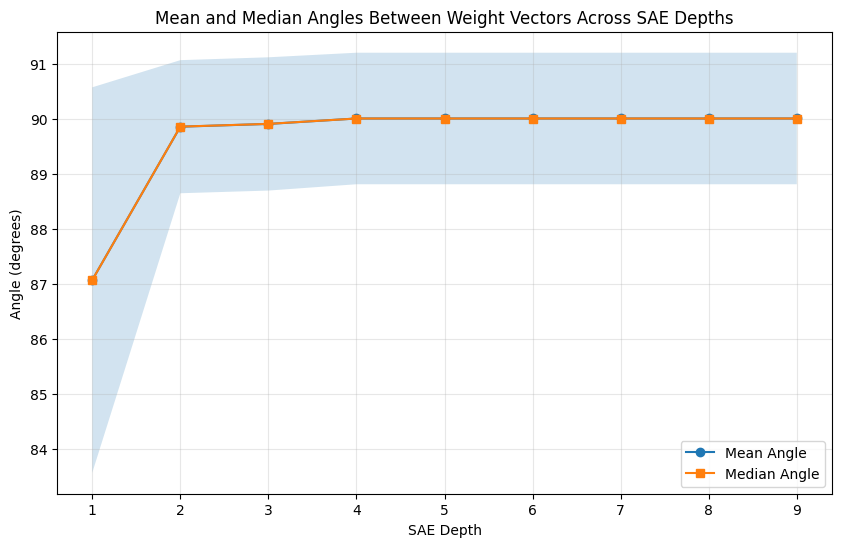

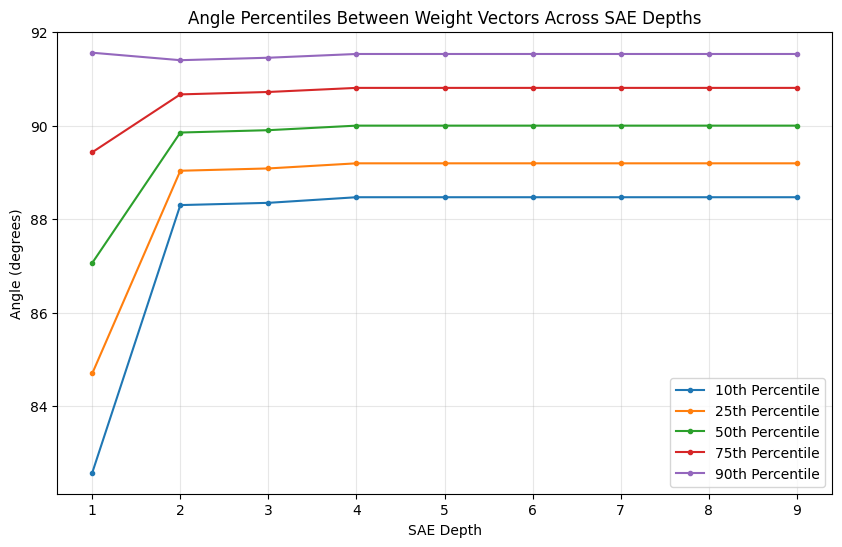

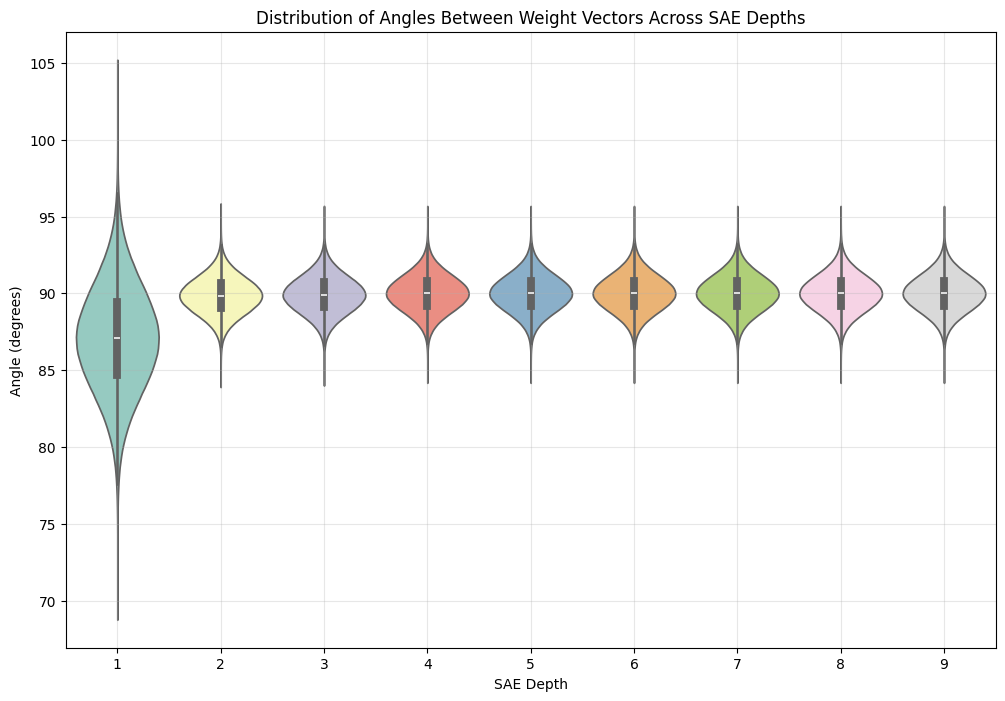

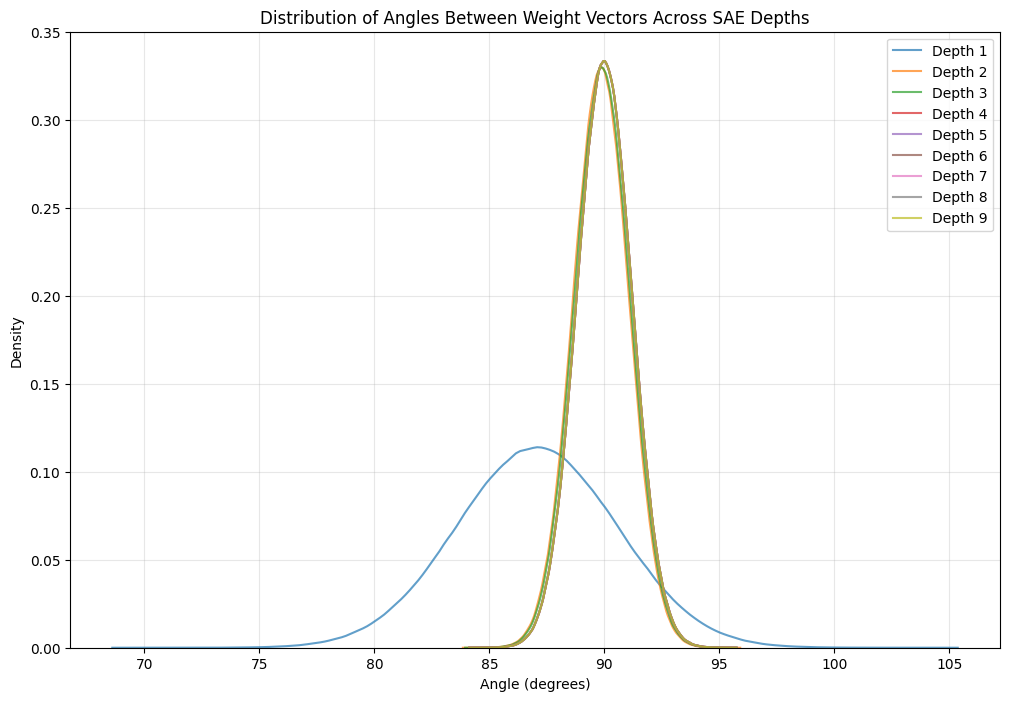

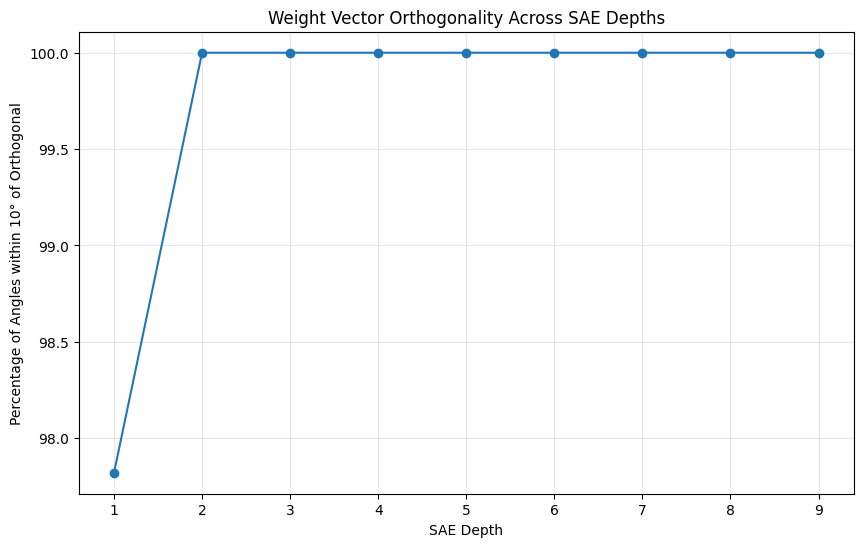


Summary of Weight Vector Angle Analysis:
Analyzed 9 SAE depths

Depth 1:
  Mean angle: 87.07°
  Median angle: 87.07°
  Std deviation: 3.50°
  Range: 69.08° - 104.89°
  Near-orthogonal vectors: 97.82%

Depth 2:
  Mean angle: 89.85°
  Median angle: 89.85°
  Std deviation: 1.21°
  Range: 84.01° - 95.74°
  Near-orthogonal vectors: 100.00%

Depth 3:
  Mean angle: 89.90°
  Median angle: 89.90°
  Std deviation: 1.21°
  Range: 84.11° - 95.58°
  Near-orthogonal vectors: 100.00%

Depth 4:
  Mean angle: 90.00°
  Median angle: 90.00°
  Std deviation: 1.19°
  Range: 84.28° - 95.58°
  Near-orthogonal vectors: 100.00%

Depth 5:
  Mean angle: 90.00°
  Median angle: 90.00°
  Std deviation: 1.19°
  Range: 84.28° - 95.58°
  Near-orthogonal vectors: 100.00%

Depth 6:
  Mean angle: 90.00°
  Median angle: 90.00°
  Std deviation: 1.19°
  Range: 84.28° - 95.58°
  Near-orthogonal vectors: 100.00%

Depth 7:
  Mean angle: 90.00°
  Median angle: 90.00°
  Std deviation: 1.19°
  Range: 84.28° - 95.58°
  Near-ortho

In [11]:
plot_angle_stats(angle_stats)
plot_angle_distributions(similarity_distributions, angle_stats)
orthogonality_metrics = calculate_orthogonality_metrics(angle_stats, similarity_distributions)

# Print summary
print("\nSummary of Weight Vector Angle Analysis:")
print("=======================================")
print(f"Analyzed {len(angle_stats)} SAE depths")

for i, stat in enumerate(angle_stats):
    depth = stat['depth']
    print(f"\nDepth {depth}:")
    print(f"  Mean angle: {stat['mean']:.2f}°")
    print(f"  Median angle: {stat['median']:.2f}°")
    print(f"  Std deviation: {stat['std']:.2f}°")
    print(f"  Range: {stat['min']:.2f}° - {stat['max']:.2f}°")
    print(f"  Near-orthogonal vectors: {orthogonality_metrics[i]:.2f}%")

### Visualize

In [23]:
def visualize_concept_purity(activations_by_depth, dataset, labels, depths=[1, 3, 5, 9]):
    """
    Visualize how concept purity changes across depths.
    
    Args:
        activations_by_depth: Dictionary mapping depth to activation tensors
        dataset: MNIST dataset containing images
        labels: Class labels for the dataset
        depths: List of depths to visualize
    """
    num_features = min([activations_by_depth[d].shape[1] for d in depths])
    num_classes = 10  # For MNIST
    
    # For each depth, compute class distribution for each feature
    class_distributions = {}
    
    for depth in depths:
        activations = activations_by_depth[depth]
        labels_tensor = torch.tensor(labels)
        
        # Initialize class distribution matrix
        distributions = torch.zeros(num_features, num_classes)
        
        # For each feature, find top 100 activating examples
        for feature_idx in range(num_features):
            top_indices = torch.topk(activations[:, feature_idx], 100).indices
            
            # Count class distribution in top activations
            for idx in top_indices:
                class_label = labels_tensor[idx].item()
                distributions[feature_idx, class_label] += 1
            
            # Normalize to get percentages
            if distributions[feature_idx].sum() > 0:
                distributions[feature_idx] = distributions[feature_idx] / distributions[feature_idx].sum()
        
        class_distributions[depth] = distributions
    
    # Create visualization
    fig, axes = plt.subplots(len(depths), 1, figsize=(12, 4*len(depths)))
    
    for i, depth in enumerate(depths):
        # Calculate entropy for each feature (lower entropy = higher purity)
        distributions = class_distributions[depth]
        entropy = -torch.sum(
            distributions * torch.log2(distributions + 1e-10), 
            dim=1
        )
        
        # Sort features by entropy
        sorted_indices = torch.argsort(entropy)
        
        # Display class distribution heatmap for top 30 features
        im = axes[i].imshow(
            distributions[sorted_indices[:30]].numpy(), 
            aspect='auto', 
            cmap='Blues'
        )
        
        axes[i].set_title(f'Depth {depth}: Class Distribution for Top 30 Features (by purity)')
        axes[i].set_ylabel('Feature Index')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks(range(10))
        
    plt.tight_layout()
    plt.savefig('concept_purity_across_depths.png')
    plt.close()
    
    # Also create a summary plot of average entropy by depth
    plt.figure(figsize=(10, 6))
    avg_entropy = [torch.mean(
        -torch.sum(class_distributions[d] * torch.log2(class_distributions[d] + 1e-10), dim=1)
    ).item() for d in depths]
    
    plt.plot(depths, avg_entropy, 'o-', linewidth=2)
    plt.xlabel('Depth')
    plt.ylabel('Average Entropy (lower = more pure)')
    plt.title('Feature Concept Purity Across Depths')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('average_concept_purity.png')
    plt.close()

In [26]:
visualize_concept_purity(activations_by_depth=activation_dict, dataset=dataset, labels=labels, depths=[1, 2, 3])

#### Evolution

In [34]:
def visualize_feature_evolution(activations_by_depth, dataset, feature_idx, max_depth=9, top_k=5, similarity_threshold=0.3):
    """
    Visualize how a specific feature at depth 1 evolves through subsequent depths.
    
    Args:
        activations_by_depth: Dictionary mapping depth to activation tensors
        dataset: MNIST dataset containing images
        feature_idx: Index of the feature at depth 1 to track
        max_depth: Maximum depth to visualize
        top_k: Number of top activating images to show per feature
        similarity_threshold: Minimum cosine similarity to consider a feature related
    """
    # Get feature at depth 1
    base_activations = activations_by_depth[1]
    base_feature = base_activations[:, feature_idx]
    
    # Create figure
    fig_width = 15
    fig_height = 2.5 * min(max_depth, 9)  # Limit height for very deep models
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Show top activating images for base feature
    base_top_indices = torch.topk(base_feature, top_k).indices
    for j, idx in enumerate(base_top_indices):
        ax = plt.subplot(max_depth, top_k, j+1)
        # Handle colored MNIST with shape [3, 28, 28]
        img = dataset[idx][0].permute(1, 2, 0).numpy()
        # Convert to grayscale for visualization
        img = img.mean(axis=2)
        ax.imshow(img, cmap='gray')
        activation_value = base_feature[idx].item()
        ax.set_title(f'{activation_value:.2f}', fontsize=8)
        ax.axis('off')
    
    # Label for base feature
    plt.figtext(0.02, 1.0 - 0.5/fig_height, f'Depth 1\nFeature {feature_idx}', 
                fontsize=10, ha='left', va='center')
    
    # Track feature evolution through depths
    related_features = {1: [feature_idx]}
    
    # For each subsequent depth
    for depth in range(2, max_depth + 1):
        if depth not in activations_by_depth:
            continue
            
        current_activations = activations_by_depth[depth]
        related_features[depth] = []
        
        # For each feature in previous depth, find related features in current depth
        for prev_feature in related_features[depth-1]:
            prev_feature_activations = activations_by_depth[depth-1][:, prev_feature]
            
            # Find similar features in current depth
            similarities = []
            for curr_idx in range(current_activations.shape[1]):
                curr_feature = current_activations[:, curr_idx]
                similarity = torch.nn.functional.cosine_similarity(
                    prev_feature_activations.unsqueeze(0), 
                    curr_feature.unsqueeze(0)
                ).item()
                if similarity > similarity_threshold:
                    similarities.append((curr_idx, similarity))
            
            # Sort by similarity
            similarities.sort(key=lambda x: x[1], reverse=True)
            for curr_idx, sim in similarities[:3]:  # Limit to top 3 most similar features
                if curr_idx not in related_features[depth]:
                    related_features[depth].append(curr_idx)
        
        # Display top activating images for each related feature at this depth
        features_to_display = related_features[depth][:top_k]  # Limit number of features displayed
        
        for i, curr_feature in enumerate(features_to_display):
            # Get top activating images for this feature
            curr_top_indices = torch.topk(current_activations[:, curr_feature], top_k).indices
            
            for j, idx in enumerate(curr_top_indices):
                # Calculate position in grid
                pos = (depth - 1) * top_k + j + 1
                if pos <= max_depth * top_k:  # Ensure we don't go out of bounds
                    ax = plt.subplot(max_depth, top_k, pos)
                    # Handle colored MNIST with shape [3, 28, 28]
                    img = dataset[idx][0].permute(1, 2, 0).numpy()
                    # Convert to grayscale for visualization
                    img = img.mean(axis=2)
                    ax.imshow(img, cmap='gray')
                    activation_value = current_activations[idx, curr_feature].item()
                    ax.set_title(f'{activation_value:.2f}', fontsize=8)
                    ax.axis('off')
            
            # Label for this feature
            plt.figtext(0.02, 1.0 - (depth-0.5)/max_depth, 
                      f'Depth {depth}\nFeature {curr_feature}', 
                      fontsize=10, ha='left', va='center')
            
            # Break after first feature at each depth for clearer visualization
            break
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)
    plt.savefig(f'feature_{feature_idx}_evolution.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    return related_features

In [35]:
def visualize_feature_split_graph(related_features, activations_by_depth, feature_idx, max_depth=9):
    """
    Create a network graph visualization showing how a feature splits across depths.
    
    Args:
        related_features: Dictionary from visualize_feature_evolution
        activations_by_depth: Dictionary mapping depth to activation tensors
        feature_idx: Index of the feature at depth 1 being tracked
        max_depth: Maximum depth to visualize
    """
    import networkx as nx
    
    # Create graph
    G = nx.DiGraph()
    
    # Add nodes for each depth and feature
    node_positions = {}
    for depth in range(1, max_depth + 1):
        if depth not in related_features:
            continue
            
        features = related_features[depth]
        for i, f_idx in enumerate(features):
            # Create unique node ID
            node_id = f"D{depth}_F{f_idx}"
            
            # Add node with attributes
            activation_mean = activations_by_depth[depth][:, f_idx].mean().item()
            G.add_node(node_id, depth=depth, feature=f_idx, 
                      activation=activation_mean, label=f"F{f_idx}")
            
            # Set position for nice layout: depth on x-axis, spread features on y-axis
            x_pos = depth 
            y_pos = i - len(features)/2
            node_positions[node_id] = (x_pos, y_pos)
            
    # Add edges between depths
    for depth in range(2, max_depth + 1):
        if depth not in related_features or depth-1 not in related_features:
            continue
            
        current_features = related_features[depth]
        prev_features = related_features[depth-1]
        
        # For each feature in current depth, connect to similar features in previous depth
        for curr_feature in current_features:
            curr_feature_activations = activations_by_depth[depth][:, curr_feature]
            
            for prev_feature in prev_features:
                prev_feature_activations = activations_by_depth[depth-1][:, prev_feature]
                
                # Calculate similarity
                similarity = torch.nn.functional.cosine_similarity(
                    prev_feature_activations.unsqueeze(0), 
                    curr_feature.unsqueeze(0)
                ).item()
                
                if similarity > 0.2:  # Only connect if somewhat similar
                    G.add_edge(f"D{depth-1}_F{prev_feature}", 
                              f"D{depth}_F{curr_feature}", 
                              weight=similarity)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Draw nodes
    node_colors = [G.nodes[n]['activation'] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos=node_positions, 
                         node_color=node_colors, 
                         cmap=plt.cm.viridis,
                         node_size=300,
                         alpha=0.8)
    
    # Draw edges with width proportional to similarity
    edge_widths = [G[u][v]['weight'] * 3 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos=node_positions, 
                         width=edge_widths,
                         alpha=0.6,
                         edge_color='gray',
                         arrows=True,
                         arrowsize=10)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos=node_positions, 
                          labels=nx.get_node_attributes(G, 'label'),
                          font_size=9)
    
    # Add title and labels
    plt.title(f"Feature {feature_idx} Splitting Across Depths")
    plt.grid(False)
    plt.axis('off')
    
    # Add depth labels along x-axis
    for depth in range(1, max_depth + 1):
        if depth in related_features:
            plt.text(depth, -2, f"Depth {depth}", 
                   ha='center', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'feature_{feature_idx}_split_graph.png', dpi=150, bbox_inches='tight')
    plt.close()

  0%|          | 5/2304 [26:50<205:41:27, 322.09s/it]


KeyboardInterrupt: 

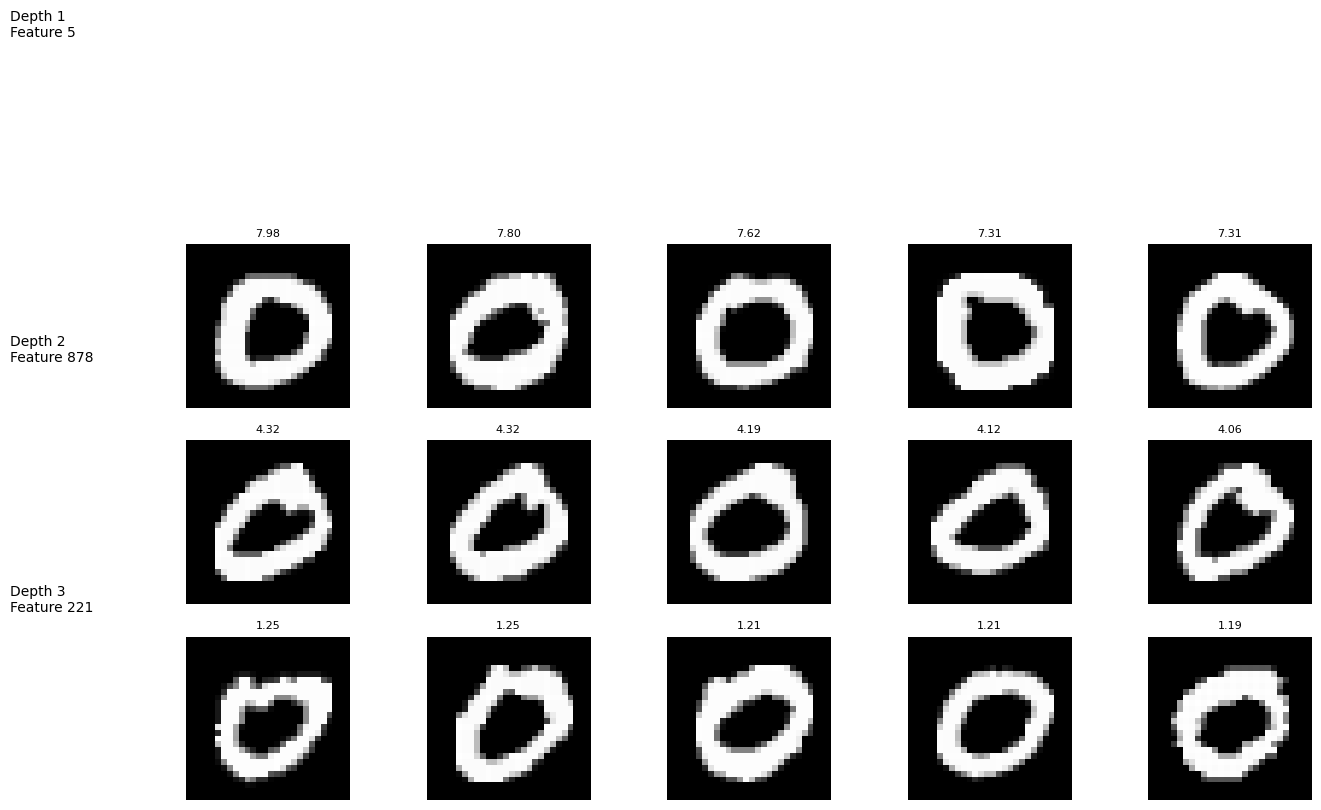

In [41]:
related_dict = {}
for i in tqdm(range(0, 2304)):
    related_features = visualize_feature_evolution(activations_by_depth=activation_dict, dataset=dataset, feature_idx=i)
    related_dict[i] = related_features

In [38]:
visualize_feature_split_graph(related_features=related_features, activations_by_depth=activation_dict, feature_idx=1)

AttributeError: 'int' object has no attribute 'unsqueeze'